In [50]:
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

In [51]:
keywords = pd.read_csv('keywords_preprocessed.csv')
meta = pd.read_csv('movies_metadata_preprocessed.csv')
ratings = pd.read_csv('ratings_preprocessed.csv')

In [221]:
df_numeric = meta[['budget','popularity','revenue','runtime','vote_average','vote_count']]
df_numeric.dropna(inplace=True)

train,test = train_test_split(df_numeric,test_size=0.25)

/Users/prajwalkirankumar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [222]:
x = train.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.columns = df_numeric.columns

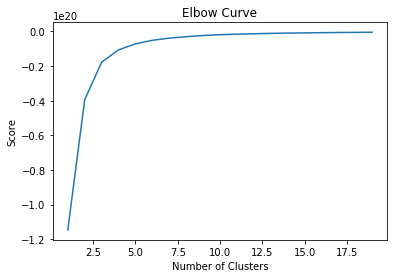

In [224]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
y = np.array(train.revenue).reshape(-1,1)
score = [kmeans[i].fit(y).score(y) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [341]:
kmeans = KMeans(n_clusters=4)
pred = kmeans.fit(y).predict(y)
train['cluster'] = kmeans.labels_


/Users/prajwalkirankumar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [227]:
[len(train[train.cluster==i]) for i in range(4)]

[4309, 267, 81, 877]

In [228]:
[train[train.cluster==i].revenue.mean() for i in range(4)]

[17479758.513344165, 399874618.88389516, 914204166.308642, 147611848.7628278]

In [229]:
train.groupby(['cluster']).mean()

,budget,popularity,revenue,runtime,vote_average,vote_count
cluster,,,,,,
0,1.082423e+07,6.594573,1.747976e+07,105.943142,6.149408,227.670689
1,9.708828e+07,18.022921,3.998746e+08,117.022472,6.645318,2778.895131
2,1.589012e+08,44.119673,9.142042e+08,130.419753,6.969136,5462.864198
3,4.800756e+07,12.247029,1.476118e+08,112.640821,6.382098,1112.751425


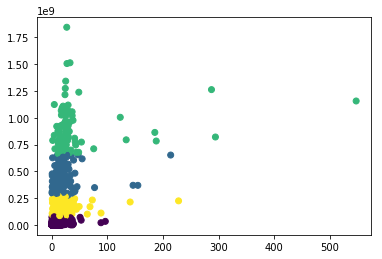

In [232]:
size_array = list(train.groupby(['cluster']).count()['revenue'].values)
train[train['cluster']==size_array.index(sorted(size_array)[0])].revenue.mean()
plt.scatter(train.popularity,train.revenue,c=kmeans.labels_)
plt.show()

In [235]:
cluster1 = train[train.cluster==1]
cluster1 = cluster1[cluster1.revenue!=0]
len(cluster1)

267

In [247]:
test_clusters = kmeans.predict(test.revenue.reshape(-1,1))
test['cluster'] = test_clusters
print(train.groupby(['cluster']).mean())
print(test.groupby(['cluster']).mean())

               budget  popularity       revenue     runtime  vote_average  \
cluster                                                                     
0        1.082423e+07    6.594573  1.747976e+07  105.943142      6.149408   
1        9.708828e+07   18.022921  3.998746e+08  117.022472      6.645318   
2        1.589012e+08   44.119673  9.142042e+08  130.419753      6.969136   
3        4.800756e+07   12.247029  1.476118e+08  112.640821      6.382098   

          vote_count  
cluster               
0         227.670689  
1        2778.895131  
2        5462.864198  
3        1112.751425  
               budget  popularity       revenue     runtime  vote_average  \
cluster                                                                     
0        1.063108e+07    6.711234  1.736146e+07  105.712432      6.177869   
1        9.438765e+07   15.765085  4.041839e+08  116.012346      6.490123   
2        1.685625e+08   42.710566  1.013767e+09  131.333333      7.000000   
3        4.490

/Users/prajwalkirankumar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.
/Users/prajwalkirankumar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [340]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

X = train[['budget','popularity','runtime','vote_average','vote_count']]
# y = (train[['revenue']])
y = np.log(train[['revenue']])
print(y)
lm = linear_model.LinearRegression()
model = lm.fit(X,y)
predictions = lm.predict(X)
pred = pd.DataFrame(predictions,columns=["revenue"])
y['revenue_pred'] = predictions
y = y[y.revenue_pred>0]

# log_y = np.log10(y.revenue)
# log_y_pred = np.log10(y.revenue_pred)
# print(mean_squared_error(log_y,log_y_pred))
print(mean_squared_error(y.revenue,y.revenue_pred))

print(y)
residuals = y.revenue - y.revenue_pred
print(residuals)
# plt.scatter(y.revenue,y.revenue_pred)
# plt.scatter(residuals,y.revenue_pred)
plt.show()

print(model.score(X,y.revenue))

        revenue
7047  18.617812
2223  18.074704
611   18.705860
4317  17.416119
4871  19.445759
3819  16.914052
5914  20.374725
5245  18.665435
3479  15.977963
6072  14.914123
125   16.688464
4641  18.705108
893   18.846491
6890  18.504641
843   14.914123
766   16.675424
5390  19.296813
52    19.019609
6531  14.346139
6662  16.830162
5389  12.106843
2404  17.353894
1312  12.823062
11    18.570069
4352  14.817786
3351  15.808711
936   19.219538
1278  15.424948
1879  17.622173
6677  10.171375
...         ...
5712  12.672890
7204  10.338867
7356  20.069103
3596  18.389087
7186  16.023785
6846  16.588099
113   16.915603
336   20.521112
2243  16.907916
6131   8.877800
5227  18.891388
2820  12.663497
3472  17.574073
4900  18.146244
1993  15.925474
1066  15.886921
3459   4.700480
5973  12.214076
5583   8.557567
2423  19.011919
2864  17.032062
4945  17.115857
5811  18.278644
7352  12.273731
1236  16.736740
1586  11.968101
3750  18.723228
5755  16.884527
5347  15.988479
5174  12.781809

[5534 r